In [1]:
import numpy as np
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from utils import clean, encrypt, get_message
%matplotlib inline

In [3]:
class MetropolisDecryptor:
    def __init__(self, alphabet, m, scaling_factor=1.0, broken=False):

        # Символы алфавита от более часых к менее частым. (включая пробел)
        self.alphabet = alphabet

        # "Матрица" переходов. Словарь, по паре символов даёт логарифм количества
        # таких пар в тексте, на котором мы тренировались
        self.m = m

        # Из статьи. Не пригодился
        self.scaling_factor = scaling_factor

        # Если True, то принимаем только замены, увеличивающие score.
        # То есть наивный подход к оптимизации
        self.broken = broken

        self.symbols = []
        self.text = ''
        self.log_score = 0
        self.best_score = 0
        self.map = {}              # соответствие символ -> буква или пробел
        self.best_map = {}
        self.accept_history = []   # булевый массив "принимали замену или нет"
        self.score_history = []

    def compute_score(self, cur_map):
        """Вычислить score текста, расшифрованоого данной cur_map"""
        m_values = np.zeros(len(self.text) - 1, dtype=np.float64)
        for i in range(len(self.text) - 1):
            pair = ''.join(cur_map[ch] for ch in self.text[i:i + 2])
            m_values[i] = self.m[pair]
        return m_values.sum()

    def start_from(self, s, stat=True):
        """Обработать новый текст, инициализировать параметры

        s: текст
        stat: если True, то исходное соответсвие - частым символам частые буквы"""

        sym = set(s)
        if not s:
            print('Empty text!')
            return False
        if len(sym) > len(self.alphabet):
            print(f'Too many symbols: {"".join(sym)}')
            return False
        self.text = s
        self.symbols = sorted(list(sym))
        if stat:
            # Сортируем в порядке частоты в тексте
            cnt = Counter(s)
            self.symbols.sort(key=cnt.get, reverse=True)
        self.map = dict(zip(self.symbols, self.alphabet))
        self.log_score = self.compute_score(self.map)
        self.best_map = self.map.copy()
        self.best_score = self.log_score
        self.accept_history = []
        self.score_history = []
        return True

    def metropolis_step(self):
        """Шаг алгоритма"""
        # Случайно выбираем два символа
        sym1, sym2 = np.random.choice(self.symbols, 2, replace=False)
        # Создаём новую map, где они перествалены
        new_map = self.map.copy()
        new_map[sym1], new_map[sym2] = new_map[sym2], new_map[sym1]

        # Берём старый и новый score
        old_score = self.log_score
        new_score = self.compute_score(new_map)

        # Усовие из алгоритма Метрополиса
        metropolis_condition = np.log(np.random.rand()) < (new_score - old_score) * self.scaling_factor

        # Принять или не принять
        if new_score > old_score or (not self.broken and metropolis_condition):
            self.map = new_map
            self.log_score = new_score
            if self.log_score > self.best_score:
                self.best_score = self.log_score
                self.best_map = self.map
            self.accept_history.append(True)
        else:
            self.accept_history.append(False)
        self.score_history.append(self.log_score)

    def run(self, num_steps, verbose=False, print_every=100, length=100, early_stop=1000):
        """Сделать несколько шагов

        length: какой длины выводить текст
        early_stop: если best_score не увеличивается столько шагов, то закончить"""

        if verbose:
            print('Initial text   : ' + self.decrypt(self.map, length))
        not_improving = 0
        for step_num in range(num_steps):
            old_best = self.best_score
            self.metropolis_step()
            if self.best_score > old_best:
                not_improving = 0
            else:
                not_improving += 1
            if not_improving == early_stop:
                break
            if verbose and (step_num + 1) % print_every == 0:
                print(f'Iteration {step_num + 1:5d}: ' + self.decrypt(self.map, length))
        if verbose:
            print('Best score     : ' + self.decrypt(self.best_map, length))

    def decrypt(self, cur_map, length=None):
        """Расшифровать текст данной cur_map

        length: сколько начальных символов перев"""
        return ''.join(cur_map[ch] for ch in self.text[:length])

    def acc_rate(self):
        """Процент шагов, принвших замену"""
        acc = np.array(self.accept_history, dtype=bool)
        return f'{100 * acc.sum() / len(acc):.2f}%'

    def final(self):
        """Расшифровка лучшей полученной map"""
        return self.decrypt(self.best_map)

    def plot(self):
        """График score по итерациям"""
        ax = plt.gca()
        plt.plot(self.score_history)
        ax.set_ylabel('Score')
        ax.set_xlabel('Iteration')
        plt.show()

In [4]:
# Возьмём расшифровщиков

alphabet_ru, m_ru = pickle.load(open('models/ru.pkl', 'rb'))
decryptor_ru = MetropolisDecryptor(alphabet_ru, m_ru)

alphabet_en, m_en = pickle.load(open('models/en.pkl', 'rb'))
decryptor_en = MetropolisDecryptor(alphabet_en, m_en)

#### Варианты для текстов:

* каренина - 9739
* поттер - 3786
* гамлет - 1159
* тютчев - 438



* warpeace - 10912
* synthesis - 2236
* hamlet - 1434
* dylan - 833


In [128]:
# Возьмём сообщение

initial, encrypted = get_message('гамлет', 300)

print(initial[:80])
print(encrypted[:80])

быть или не быть вот в чём вопрос достойно ль смиряться под ударами судьбы иль н
⊃⊢⊥⊪∉∀ℤ∀∉≭⨖∉⊃⊢⊥⊪∉⨒⊂⊥∉⨒∉⊯⊭∌∉⨒⊂⊩⊣⊂⊠∉⋫⊂⊠⊥⊂∈≭⊂∉ℤ⊪∉⊠∌∀⊣⊲⊥⊪⊠⊲∉⊩⊂⋫∉⋬⋫≿⊣≿∌∀∉⊠⋬⋫⊪⊃⊢∉∀ℤ⊪∉≭


In [176]:
# Настроим расшифровщик

decryptor = decryptor_ru

decryptor.broken = False
decryptor.scaling_factor = 0.5

# Изначальное соответствие символ -> буква

decryptor.start_from(initial, stat=True)
print(decryptor.final()[:80])

мдит ере са мдит уои у ьэв уоякон пониочсо рт нвекыитны яоп гплклве нгптмд ерт с


In [177]:
# Запустим расшифровщик

decryptor.run(50000, verbose=True, print_every=1000, length=80, early_stop=None)

Initial text   : мдит ере са мдит уои у ьэв уоякон пониочсо рт нвекыитны яоп гплклве нгптмд ерт с
Iteration  1000: гуто иди не гуто лат л чюс лакрав мавтайна до всирытовы кам ьмяряси вьмогу идо н
Iteration  2000: гуто иди не гуто ват в чюл вакрас мастайна до слирьтось кам ямырыли сямогу идо н
Iteration  3000: чута ими не чута вот в дюл вогрос зостойно ма слирьтась гоз язырыли сязачу има н
Iteration  4000: пута изи не пута вот в кюл вогрос мостойно за слирьтась гом ямырыли сямапу иза н
Iteration  5000: быту ими не быту вот в дюл вопрос гостойно му слирьтусь пог ягарали сягубы иму н
Iteration  6000: быть иди не быть вот в кюл вопрос гостойно дь слирутьсу пог ягарали сягьбы идь н
Iteration  7000: быть иди не быть вот в гшл вопрос мостойно дь слиряться пом умарали сумьбы идь н
Iteration  8000: быть иди не быть вот в чюм вопрос гостойно дь смиряться пог угарами сугьбы идь н
Iteration  9000: быть иди не быть вот в гюл вопрос мостойно дь слиряться пом умарали сумьбы идь н
Iteration 10000: быт

In [178]:
# Лучший результат

print(decryptor.final())

быть или не быть вот в дюм вопрос гостойно ль смиряться пог угарами сугьбы иль наго оказать сопротивленье и в смертной схватке с челым морем бег покондить с ними умереть забыться и знать дто этим обрываешь чепь сергедных мук и тысяди лишений присужих телу это ли не чель целанная скондаться сном забы


In [179]:
# Доля принятых замен

print(decryptor.acc_rate())

1.29%


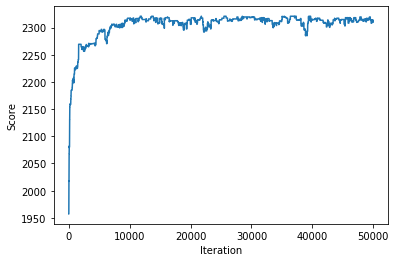

In [180]:
# История score

decryptor.plot()